# Linear Regression using Pyro

### Basic Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

t_dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating dataset

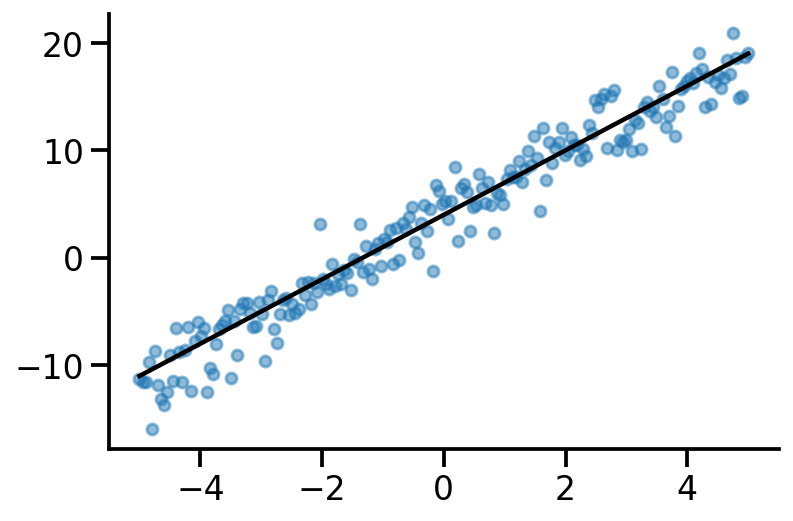

In [ ]:
x = torch.linspace(-5, 5, 200)
true_y = 3*x + 4 
observed_y = true_y+ 2*torch.randn(200)

plt.scatter(x, observed_y, s = 30, alpha=0.5)
plt.plot(x, true_y, color = 'k')


sns.despine()

### MLE

In [ ]:
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

pyro.clear_param_store()


def mle_model(x, y=None):
    theta_0 = pyro.param("theta_0", torch.randn(1))
    theta_1 = pyro.param("theta_1", torch.randn(1))
    y_hat_mean = theta_0 + theta_1*x

    with pyro.plate("data", len(x)):
        return pyro.sample("obs", dist.Normal(y_hat_mean, 1), obs=y)

#pyro.render_model(mle_model, model_args=(x, observed_y))

In [ ]:
m = mle_model(x)
pyro.param("theta_0").item(), pyro.param("theta_1").item()

(-0.100727379322052, 1.5172470808029175)

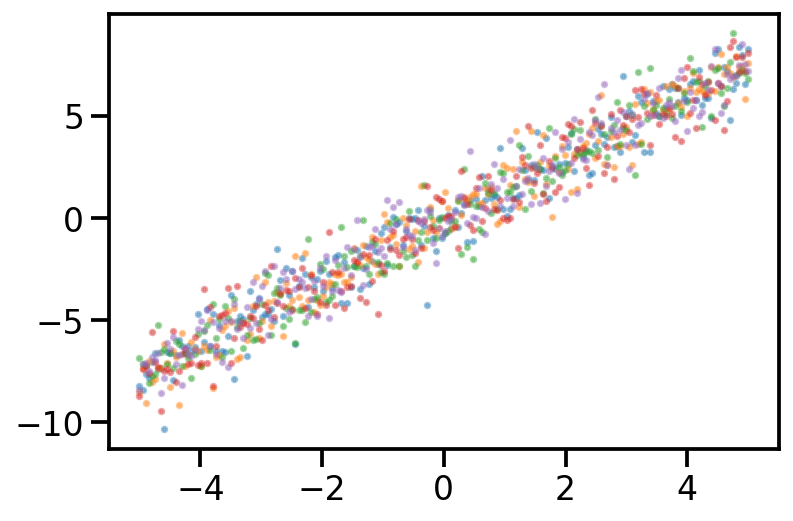

In [ ]:
for i in range(5):
    plt.scatter(x, mle_model(x).detach(), s = 5, alpha = 0.4)
    plt.plot(x, )

In [ ]:
def guide(x, y):
    # register the two variational parameters with Pyro.
    pyro.sample("theta_0", dist.Normal(0., 1.))
    pyro.sample("theta_1", dist.Normal(0., 1.))


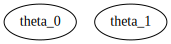

In [ ]:
pyro.render_model(guide, model_args=(x, observed_y))

In [ ]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(mle_model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(x, y)
    if step%110==0:
        print(pyro.param("theta_0").item(), pyro.param("theta_1").item())

/Users/nipun/miniforge3/lib/python3.9/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'theta_1', 'theta_0'}
  warnings.warn(


ValueError: Error while computing log_prob at site 'obs':
Value is not broadcastable with batch_shape+event_shape: torch.Size([100]) vs torch.Size([200]).
Trace Shapes:      
 Param Sites:      
      theta_0     1
      theta_1     1
Sample Sites:      
     obs dist 200 |
        value 100 |

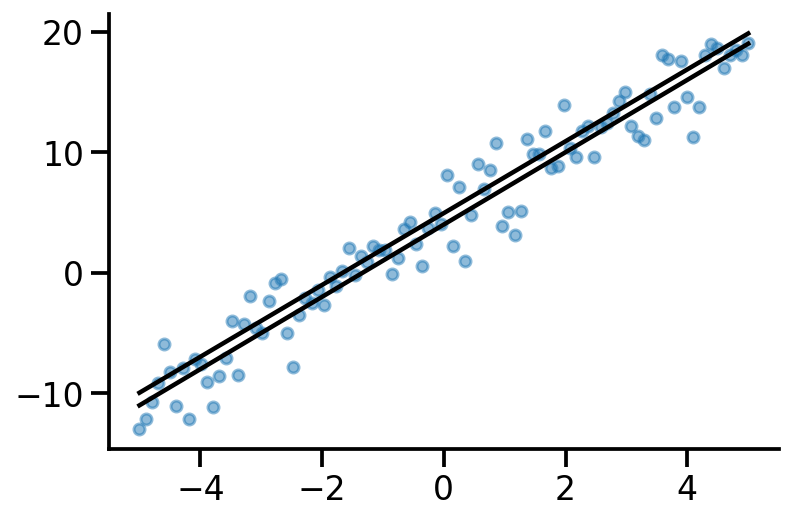

In [ ]:
x = torch.linspace(-5, 5, 100)
predicted_y = pyro.param("theta_1").item()*x + pyro.param("theta_0").item()
#observed_y = true_y+ 2*torch.randn(100)

plt.scatter(x, observed_y, s = 30, alpha=0.5)
plt.plot(x, predicted_y, color = 'k')
plt.plot(x, true_y, color = 'k')



sns.despine()

In [ ]:
data_dim = 2
latent_dim = 1
num_datapoints = 100
z = dist.Normal(
    loc=torch.zeros([latent_dim, num_datapoints]),
    scale=torch.ones([latent_dim, num_datapoints]),)

w = dist.Normal(
    loc=torch.zeros([data_dim, latent_dim]),
    scale=5.0 * torch.ones([data_dim, latent_dim]),
)

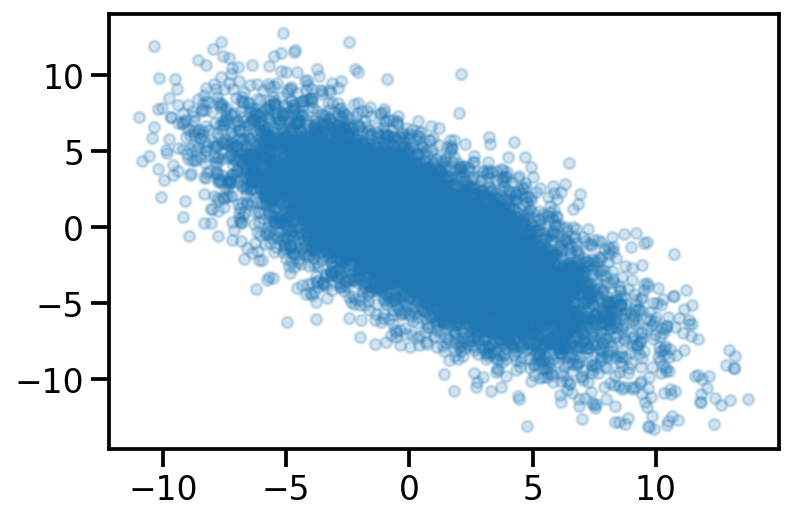

In [ ]:
w_sample= w.sample()
z_sample = z.sample()


x = dist.Normal(loc = w_sample@z_sample, scale=2)
x_sample = x.sample([100])
plt.scatter(x_sample[:, 0], x_sample[:, 1], alpha=0.2, s=30)

### Generative model for PPCA in Pyro

In [ ]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pyro
pyro.clear_param_store()

def ppca_model(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.param("W", torch.zeros((data_dim, latent_dim)))
    #print(W.shape, data_dim, (data_dim, latent_dim))
    
    for i in range(N):
        z_vec = pyro.sample("z_{}".format(i), dist.Normal(loc = torch.zeros(latent_dim), scale = 1.))
        #print(W.shape, z.shape, W@z)
        pyro.sample(fr"\$x_{i}\$", dist.Normal(W@z_vec, 2.), obs=data[i])


pyro.render_model(ppca_model, model_args=(torch.randn(150, 3), 1))

In [ ]:
pyro.clear_param_store()

def ppca_model2(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.param("W", torch.zeros((data_dim, latent_dim)))
    #print(W.shape, data_dim, (data_dim, latent_dim))
    z_vec = pyro.sample("z", dist.Normal(loc = torch.zeros([latent_dim, N]), scale = 1.))
    
    print(W.shape, z_vec.shape, (W@z_vec).t().shape, data.shape)
    return pyro.sample("obs", (W@z_vec).t(), obs=data)
    
pyro.render_model(ppca_model2, model_args=(torch.randn(150, 3), 1))

torch.Size([3, 1]) torch.Size([1, 150]) torch.Size([150, 3]) torch.Size([150, 3])


AttributeError: 'ProvenanceTensor' object has no attribute 'log_prob'

In [ ]:
dist.Normal(loc = torch.tensor([0.]), scale = 1.).sample()

tensor([-1.2529])

In [ ]:
pyro.clear_param_store()

D = 2
d = 1

data = torch.zeros(100, D)

def ppca(data):
    A = pyro.param("A", torch.zeros((D, d)))
    mu = pyro.param("mu", torch.zeros(D))

    for i in pyro.plate("data", len(data)):
        z = pyro.sample("latent_{}".format(i), dist.Normal(torch.zeros(d), 1.0).to_event(1))
        pyro.sample("observed_{}".format(i), dist.Normal(A @ z + mu, 1.0).to_event(1), obs=data[i])

pyro.render_model(ppca, model_kwargs={'data':data})

In [ ]:
ppca(data)

In [ ]:
data.shape

torch.Size([100, 2])

In [ ]:
N = 1000
x = np.random.normal(loc = 5, scale = 1., size = N)

In [ ]:
o = {}
for i in range(N-2):
    o[i] = x[:i+2].std()

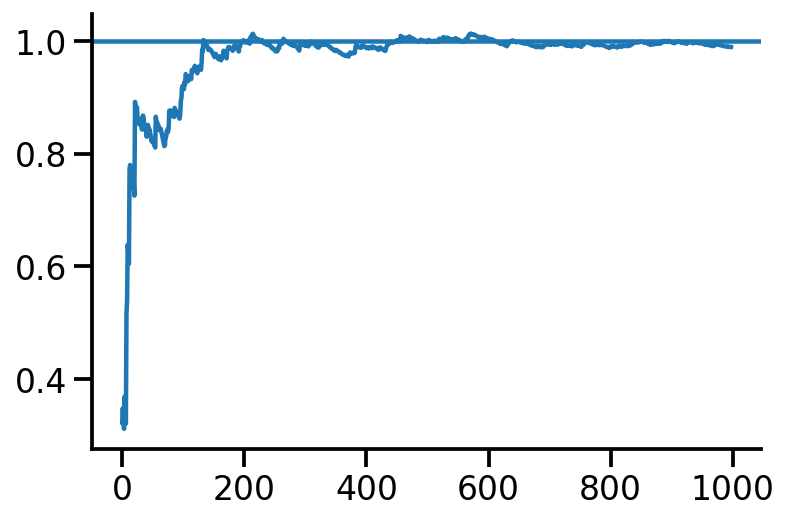

In [ ]:
pd.Series(o).plot()
plt.axhline(y=1)
sns.despine()

In [ ]:
x2 = np.array(list(o.values()))

In [ ]:
o2 = {}
for i in range(N-3):
    o2[i] = x2[:i+2].std()

<AxesSubplot:>

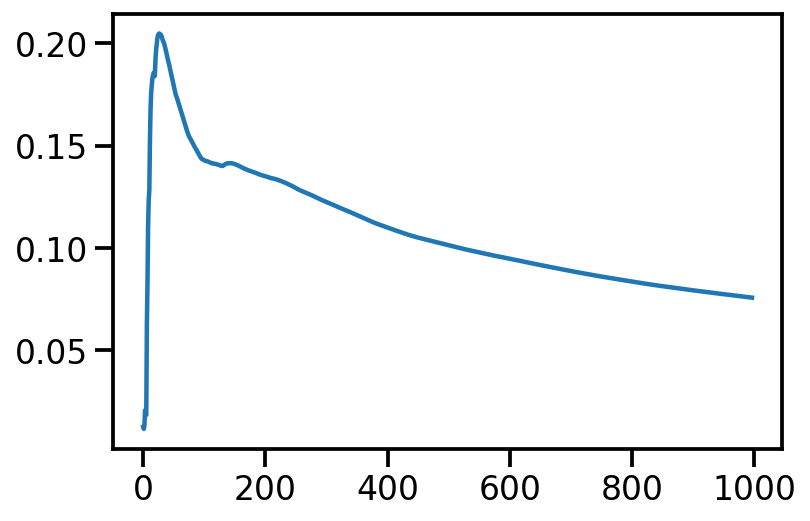

In [ ]:
pd.Series(o2).plot()